# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make coclusions) then **text answer** is **mandatory** and **is** part of the task
* **Do not** upload the dataset to the grading system (we already have it)
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if(y.size == 0):
      return 0
    return y.var()

In [3]:
# Test the function
assert np.allclose(H(np.array([4,2,2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    R_l = y[X[:, j] < t]
    R_r = y[X[:, j] >= t]
    return len(R_l) / len(y) * H(R_l) + len(R_r) / len(y) * H(R_r)

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def _more_tags(self):
        return {
            'requires_y': False
        }
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        for i in range(X.shape[1]):
          for t in np.unique(X[:, i]):
            if((X[X[:, i] < t].shape[1] > self.min_samples_split) and
               (X[X[:, i] >= t].shape[1] > self.min_samples_split) and (best_cost > Q(X, y, i, t))):
              best_split_column = i
              best_threshold = t
              best_cost = Q(X, y, i, t)

        if(best_cost == H(y)):
          return -1, np.max(X[:, 0]), X, y, np.array([]), np.array([])
        
        X_left = X[X[:, best_split_column] < best_threshold]
        X_right = X[X[:, best_split_column] >= best_threshold]
        y_left = y[X[:, best_split_column] < best_threshold]
        y_right = y[X[:, best_split_column] >= best_threshold]
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal =True
            node.prediction = np.mean(y)
            return
       
        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if(best_split_column == -1):
          node.is_terminal = True
          node.prediction = np.mean(y)
          return

        node.threshold = best_threshold
        node.column = best_split_column
        node.right = Node()
        node.right.depth = node.depth + 1
        node.left = Node()
        node.left.depth = node.depth + 1
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        # Check the input
        X = check_array(X, accept_sparse=False)
        y = check_array(y, ensure_2d= False)

        if y is None:
            raise ValueError('Y should not be None')
        
        if (isinstance(y[0], int)):
          raise ValueError('Unknown label type')

        if(y.shape[0] == 0):
          raise ValueError('Labels are empty')
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node, depth = 0)
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if(node.is_terminal):
          return node.prediction
        else:
          if(x[node.column] < node.threshold):
            return self.get_prediction(node.left, x)
          else:
            return self.get_prediction(node.right, x)
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

P.S. Depth of the tree is equal to the longest path from the root note to the leaf. Thus, tree with depth 1 will have exactly 1 split. 

P.P.S. Both fitted model and the training points should be on the same plot

In [8]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston_ds = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

9.55
12


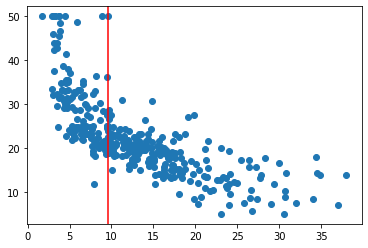

In [51]:
X = boston_ds['data']
y = boston_ds['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

tree = MyDecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train)
print(tree.tree_.threshold)
print(tree.tree_.column)

plt.scatter(X_train[:, tree.tree_.column], y_train)
plt.axvline(x = tree.tree_.threshold, color = "red")

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [52]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': np.arange(1, 9, 1), 'min_samples_split': np.arange(1, 16, 1)}
tree = MyDecisionTreeRegressor()
treeSerch = GridSearchCV(tree, parameters, cv = 5)
treeSerch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MyDecisionTreeRegressor(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

In [ ]:
from sklearn.metrics import mean_squared_error
print(treeSerch.best_estimator_)
print(mean_squared_error(treeSerch.predict(X_test), y_test) ** 0.5)

MyDecisionTreeRegressor(max_depth=6, min_samples_split=1)
4.042093171910052


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias^2 and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n\_iter}$. Each $X_i$ has $N$ observations (randomly selected from the original dataset with replacement)
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n\_iter}$, which contains all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on observations from $X_i$s and compute predictions on points from $Z_i$s
4. For a given *object* $x_n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $x_n$ was in OOB)
     - variance: variance of the predictions (predictions of the algorithms, for which $x_n$ was in OOB)
5. Average bias^2 and variance over all the points


**Consider a toy example.** You are given a dataset with 5 observations: $((x_1 ,y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4), (x_5, y_5))$, where $x_i$ is a vector of features, $y_i$ is a target variable . And choose `n_iter` to be 3. 
* Example of bootstrapped samples:
$$X_1 = (x_2, x_5, x_2, x_3, x_2, x_5)$$
$$X_2 = (x_5, x_2, x_4, x_4, x_1, x_5)$$
$$X_3 = (x_1, x_3, x_1, x_4, x_3, x_1)$$

* Corresponding OOB samples:
$$Z_1 = (x_1, x_4)$$
$$Z_2 = (x_3)$$
$$Z_3 = (x_2, x_5)$$

* Fit models using $X_1$, $X_2$ and $X_3$ as training data. Use 1st model to make predictions for points from $Z_1$, second - for $Z_2$, etc. and use these predictions to estimate bias and variance. 

    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations `n_iter`). All other operations should be vectorized. 

P.S. These numpy functions might be usefull here `np.nanmean`, `np.nanstd` (but you are not obliged to use them). 

In [ ]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias^2 and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    # YOUR CODE HERE

In [ ]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train.values, y_train, 10)

### Task 7 <a id="task7"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

In [ ]:
# YOUR CODE HERE

``` your comments here```

### Task 8 <a id="task8"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor
tree = MyDecisionTreeRegressor()
trees = BaggingRegressor(tree)

```your comments here```

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [76]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (take a look at the argument `drop` in [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to figure out the best way to apply OHE to binary variables)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)) to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_transform = make_pipeline(
                                 transform_1,
                                 transform_2
                                )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns in the dataset. 

In [77]:
missing = X.isnull().sum()
print(missing)

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
dtype: int64


In [78]:
X =X.drop('TSH', axis = 1)
X =X.drop('T3', axis = 1)
X =X.drop('T4U', axis = 1)
X =X.drop('FTI', axis = 1)
X =X.drop('TBG', axis = 1)
missing = X.isnull().sum()
print(missing)

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH_measured                   0
T3_measured                    0
TT4_measured                   0
TT4                          231
T4U_measured                   0
FTI_measured                   0
TBG_measured                   0
referral_source                0
dtype: int64


In [124]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split

# YOUR CODE HERE
# define column_transformer
transformer = FeatureUnion(
     transformer_list=[
         ('features', SimpleImputer(strategy='mean')),
         ('indicators', MissingIndicator())]
)

numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns

scaller_ohe =  ColumnTransformer([('cat', OneHotEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X_train = scaller_ohe.fit_transform(X_train)
X_test = scaller_ohe.transform(X_test)
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

transformet = make_pipeline(scaller_ohe, transformer)

# Transform the data
#X_train = transformer.fit_transform(X_train)
#X_test = transformer.transform(X_test)

In [61]:
print(X_test)

[[1.         0.         0.         ... 0.29539295 0.         0.        ]
 [1.         0.         0.         ... 0.38753388 0.         0.        ]
 [1.         0.         0.         ... 0.23577236 0.         0.        ]
 ...
 [1.         0.         0.         ... 0.18157182 0.         0.        ]
 [1.         0.         0.         ... 0.2601626  0.         0.        ]
 [0.         1.         0.         ... 0.2899729  0.         0.        ]]


### Task 2 <a id="task2_2"></a> (0.7 points  = 0.4 for code + 0.3 for comments)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

gradBoost = GradientBoostingClassifier()
perf = cross_val_score(gradBoost, X_train, y_train, cv = 5)
print(f"Gradinet boosting performed:{perf} and it's mean {np.mean(perf)}")

randomForest = RandomForestClassifier()
perf = cross_val_score(randomForest, X_train, y_train, cv = 5)
print(f"Random Forest performed:{perf} and it's mean {np.mean(perf)}")

decTree = DecisionTreeClassifier()
perf = cross_val_score(decTree, X_train, y_train, cv = 5)
print(f"Decision Tree performed:{perf} and it's mean {np.mean(perf)}")

svm = SVC()
perf = cross_val_score(svm, X_train, y_train, cv = 5)
print(f"SVM performed:{perf} and it's mean {np.mean(perf)}")

logReg = LogisticRegression(max_iter= 200)
perf = cross_val_score(logReg, X_train, y_train, cv = 5)
print(f"Logistic Regression performed:{perf} and it's mean {np.mean(perf)}")

Gradinet boosting performed:[0.9280303  0.93371212 0.93939394 0.93371212 0.93371212] and it's mean 0.9337121212121213
Random Forest performed:[0.93181818 0.93560606 0.92992424 0.93181818 0.93181818] and it's mean 0.9321969696969695
Decision Tree performed:[0.89583333 0.91666667 0.90340909 0.90719697 0.90530303] and it's mean 0.9056818181818181
SVM performed:[0.94128788 0.94128788 0.94128788 0.94128788 0.94128788] and it's mean 0.9412878787878787
Logistic Regression performed:[0.93939394 0.94128788 0.94128788 0.94128788 0.94128788] and it's mean 0.940909090909091


Согласно эксперименту все модели показали очень хорошее качество классификации. Как ожидалось самое плохое качество среди протестированных показало решающее дерево, так как оптимальные параметры в опыте для моделей не находились, то глубина решающего дерева была задана по умолчанию. Решающие деревья зачастую переобучиваются с большой глубиной дерева и недообучиваются с маленькой. Самое лучшее качество показала обычная логистическая регрессия, это очень странно, так как не налогалось никаких регуляризаций и модель могла переобучиться легко и также похоже данные хорошо линейно разделимы, поэтому обычная логистическая регрессия показала хороший результат.

### Task 3 <a id="task2_3"></a> (0.5 points = 0.4 for code + 0.1 for comments)

More Gradient Boosting. Choose one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



In [37]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [43]:
from catboost import CatBoostClassifier
catBoost = CatBoostClassifier()
parameters = {'iterations': np.arange(100, 210, 10), "learning_rate": np.arange(0.01, 0.1, 0.01), "depth" : np.array([1, 2, 4, 6, 8])}
boost = GridSearchCV(catBoost, parameters, cv = 5)
boost.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Выходные данные были обрезаны до нескольких последних строк (5000).
170:	learn: 0.1143037	total: 1.54s	remaining: 261ms
171:	learn: 0.1139667	total: 1.55s	remaining: 252ms
172:	learn: 0.1133456	total: 1.55s	remaining: 243ms
173:	learn: 0.1133007	total: 1.56s	remaining: 234ms
174:	learn: 0.1132163	total: 1.57s	remaining: 225ms
175:	learn: 0.1128582	total: 1.58s	remaining: 216ms
176:	learn: 0.1125560	total: 1.59s	remaining: 207ms
177:	learn: 0.1122905	total: 1.6s	remaining: 198ms
178:	learn: 0.1118233	total: 1.61s	remaining: 189ms
179:	learn: 0.1115018	total: 1.62s	remaining: 180ms
180:	learn: 0.1108941	total: 1.63s	remaining: 171ms
181:	learn: 0.1104740	total: 1.64s	remaining: 162ms
182:	learn: 0.1100935	total: 1.65s	remaining: 153ms
183:	learn: 0.1099300	total: 1.66s	remaining: 145ms
184:	learn: 0.1095221	total: 1.68s	remaining: 136ms
185:	learn: 0.1091400	total: 1.68s	remaining: 127ms
186:	learn: 0.1087484	total: 1.69s	remaining: 118ms
187:	learn: 0.1081099	total: 1.7s	remaining: 109m

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f0c16828750>,
             param_grid={'depth': array([1, 2, 4, 6, 8]),
                         'iterations': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]),
                         'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])})

In [50]:
print('Parameters for cat boost ', boost.best_params_)
print('Best score ', boost.best_score_)

Parameters for cat boost  {'depth': 4, 'iterations': 170, 'learning_rate': 0.04}
Best score  0.9416666666666668


При выборе библиотеки градиентного бустинга я выбрал CatBoost от Яндекса. Он может обрабатывать категориальные признаки без предобработки данных. Я часто использую данную библиотеку для бустинга. Как и ожидалось модель выбрала не очень глубокие деревья глубина которых 4 и достаточно большое количество деревьев равное 170.

### Task 4 <a id="task2_4"></a> (0.7 points = 0.4 for code + 0.3 for comments)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting as base estimators (use large amount of trees in gradient boosting, >100)
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfitting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [74]:
from sklearn.metrics import accuracy_score

from sklearn.ensemble import BaggingClassifier
treeBag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
treeBag.fit(X_train, y_train)
print(accuracy_score(treeBag.predict(X_test), y_test))

gradBoostBag = BaggingClassifier(base_estimator=GradientBoostingClassifier(), n_estimators=100, random_state=0)
gradBoostBag.fit(X_train, y_train)
print(accuracy_score(gradBoostBag.predict(X_test), y_test))

from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 =SVC()
votingClass = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
votingClass.fit(X_train, y_train)
print(accuracy_score(votingClass.predict(X_test), y_test))

from sklearn.ensemble import StackingClassifier
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),('svr', SVC())
]
stacking = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
)
stacking.fit(X_train, y_train)
print(accuracy_score(stacking.predict(X_test), y_test))

estimators = [
     ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svr', SVC())
]
stacking = StackingClassifier(
     estimators=estimators, final_estimator=GradientBoostingClassifier()
)
stacking.fit(X_train, y_train)
print(accuracy_score(stacking.predict(X_test), y_test))

0.9169611307420494
0.9381625441696113


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.9328621908127208
0.931095406360424
0.9240282685512368


Bagging with gradient boosting показал лучшее качество на тестовой выборке.
По сравнению с обычным градиентным бустингом Bagging повышает качество и уменьшает переобучение. 
При Voting классификации модели предсказывают класс и через голосование выбирают класс, но при Stacking модель просто молучают выходы модели перед ней, просто одна модель передает свои выходы следующей и финальная делает предсказания. В первом случае они предсказывают параллельно, во втором результаты используются последовательно.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to get on this dataset. 

In [ ]:
# YOUR CODE HERE